In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import casadi
import os
import sys
import statsmodels.formula.api as smf

In [88]:
PLOT = True

In [89]:
# Get COP regression as a function of T_OA
T_OA_table = list(range(-15,40,5))
COP_table = 1.7,2.3,2.3,2.43,2.63,2.78,3.36,3.79,3.99,4.12,5.10
df = pd.DataFrame({'temp':T_OA_table,'cop':COP_table})
mod = smf.ols(formula='cop ~ temp', data=df)
np.random.seed(2) 
res = mod.fit()

### Optimal OPEX

In [100]:
def optimal_opex(max_storage, max_Q_HP, forecasts):

    # Unpack forecasts and get parameters
    N = forecasts['horizon']
    elec = forecasts['elec']
    load = forecasts['load']
    COP_list = [round(res.params.Intercept+t*res.params.temp,2) for t in forecasts['T_OA']]
    min_Q_HP = max_Q_HP*0.2

    # Initialize    
    opti = casadi.Opti('conic')
 
    # -----------------------------
    # Variables and solver
    # -----------------------------
    
    Q_stor = opti.variable(1,N+1)   # state
    Q_HP = opti.variable(1,N)       # input
    delta_HP = opti.variable(1,N)   # input
    Q_HP_onoff = opti.variable(1,N) # input (derived)
    
    # delta_HP is a discrete variable (binary)
    discrete_var = [0]*(N+1) + [0]*N + [1]*N + [0]*N

    # Solver
    opti.solver('gurobi', {'discrete':discrete_var, 'gurobi.OutputFlag':0})

    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial Q_stor level
    opti.subject_to(Q_stor[0] == 0)

    # Constraints at every time step
    for t in range(N+1):

        # Bounds on storage
        opti.subject_to(Q_stor[t] >= 0)
        opti.subject_to(Q_stor[t] <= max_storage)

        if t < N:
            
            # System dynamics
            opti.subject_to(Q_stor[t+1] == Q_stor[t] + Q_HP_onoff[t] - load[t])
    
            # Bounds on delta_HP
            opti.subject_to(delta_HP[t] >= 0)
            opti.subject_to(delta_HP[t] <= 1)
        
            # Bounds on Q_HP
            opti.subject_to(Q_HP[t] <= max_Q_HP)    
            opti.subject_to(Q_HP[t] >= min_Q_HP*delta_HP[t])
        
            # Bilinear to linear
            opti.subject_to(Q_HP_onoff[t] <= max_Q_HP*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] >= min_Q_HP*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] <= Q_HP[t] + min_Q_HP*(delta_HP[t]-1))
            opti.subject_to(Q_HP_onoff[t] >= Q_HP[t] + max_Q_HP*(delta_HP[t]-1))
    
    # -----------------------------
    # Objective
    # -----------------------------
    
    obj = sum(Q_HP_onoff[t]*elec[t]/COP_list[t] for t in range(N))
    opti.minimize(obj)

    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()

    Q_opt = sol.value(Q_HP_onoff)
    stor_opt = sol.value(Q_stor)
    obj_opt = round(sol.value(obj),3)
    cost_final_day = round(sum(Q_opt[t]*elec[t]/COP_list[t] for t in range(N-48-1,N-24-1)),3)

    if PLOT:

        fig, ax = plt.subplots(1,1, figsize=(13,4))
        ax2 = ax.twinx()
        ax2.step(range(N), elec, where='post', color='gray')
        ax.step(range(N), Q_opt, where='post', color='blue')
        ax.step(range(N), load, where='post', color='red')
        ax.plot(stor_opt, color='orange')
        plt.show()

        fig, ax = plt.subplots(1,1, figsize=(13,4))
        ax2 = ax.twinx()
        ax2.step(range(24), elec[-48:-24], where='post', color='gray')
        ax.step(range(24), Q_opt[-48:-24], where='post', color='blue')
        ax.step(range(24), load[-48:-24], where='post', color='red')
        ax.plot(stor_opt[-49:-24], color='orange')
        plt.title(f"middle 24h - {cost_final_day} vs {obj_opt}")
        plt.show()

    return cost_final_day

### Estimated CAPEX

In [101]:
def estimated_capex(storage_size, heatpump_size, lifetime):
    
    A = [5,8,12,16]
    C = [1984,2235,3257,3616]
    C_polyfit = np.polyfit(A, C, 2)
    capex_HP = np.polyval(C_polyfit, storage_size)

    A = [6, 9, 12]
    C = [2416, 2857, 3297]
    C_polyfit = np.polyfit(A, C, 2)
    capex_TES = np.polyval(C_polyfit, heatpump_size)

    capex = capex_HP + capex_TES

    interest_rate = 0# 0.05
    present_value = capex/((1+interest_rate)**lifetime)

    capex_daily = present_value / (365*lifetime)

    return round(capex_daily,3)

### Typical forecasts

In [102]:
df = pd.read_excel(os.getcwd()+'/data/gridworks_yearly_data.xlsx', header=3, index_col = 0)
df.index = pd.to_datetime(df.index)
df.index.name = None
df['elec'] = df['Total Delivered Energy Cost ($/MWh)']
df['load'] = df['House Power Required AvgKw']
df['T_OA'] = df['Outside Temp F']
df = df[['elec', 'load', 'T_OA']]
df.head()

,elec,load,T_OA
2022-01-01 00:00:00,69.39,5.91,25
2022-01-01 01:00:00,64.75,5.77,26
2022-01-01 02:00:00,63.84,5.67,27
2022-01-01 03:00:00,63.31,5.77,26
2022-01-01 04:00:00,63.17,5.71,26


In [103]:
loads = {}
for j in range(1,13):
    loads[f'month{j}'] = []
    for i in range(24):
        loads[f'month{j}'].append(0.75*np.median(list(df[(df.index.month==j) & (df.index.hour == i)].load)))

T_OAs = {}
for j in range(1,13):
    T_OAs[f'month{j}'] = []
    for i in range(24):
        T_OAs[f'month{j}'].append(np.median(list(df[(df.index.month==j) & (df.index.hour == i)].T_OA))) 

In [104]:
CFH_prices = {
    'WinterHDP': [0.0718, 0.0445, 0.0202, 0.011, 0.0331, 0.11, 0.2672, 0.3077, 0.2163, 0.1584, 
                  0.1264, 0.1047, 0.1318, 0.1835, 0.2485, 0.3123, 0.3961, 0.5254, 0.4974, 0.4525, 
                  0.3918, 0.3113, 0.1998, 0.1106], 
    'SpringHDP': [0.1714, 0.144, 0.1385, 0.1518, 0.1829, 0.2713, 0.4659, 0.5328, 0.28, 0.1158, 
                  0.0398, 0.0196, 0.011, 0.0188, 0.0255, 0.0632, 0.0957, 0.2358, 0.4931, 0.6618, 
                  0.5364, 0.4116, 0.2905, 0.2209], 
    'SummerHDP': [0.0864, 0.0587, 0.0385, 0.0246, 0.0165, 0.0215, 0.0359, 0.0206, 0.0106, 0.0192, 
                  0.0309, 0.0612, 0.0925, 0.1244, 0.1667, 0.2148, 0.3563, 0.4893, 0.7098, 0.7882, 
                  0.5586, 0.3326, 0.2152, 0.1487], 
    'FallHDP': [0.2052, 0.1284, 0.0792, 0.0531, 0.0551, 0.1193, 0.2737, 0.27, 0.0916, 0.011, 0.0389, 
                0.0238, 0.0366, 0.0611, 0.0998, 0.1888, 0.3046, 0.5198, 0.7248, 0.6936, 0.4961, 0.3569, 
                0.1822, 0.0413]
 }

elecs = {}
for j in range(1,13):
    if j<=2 or j==12: 
        elecs[f'month{j}'] = CFH_prices['WinterHDP']
    elif j<=5:
        elecs[f'month{j}'] = CFH_prices['SpringHDP']
    elif j<=8:
        elecs[f'month{j}'] = CFH_prices['SummerHDP']
    else:
        elecs[f'month{j}'] = CFH_prices['FallHDP']



************
MONTH 1
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


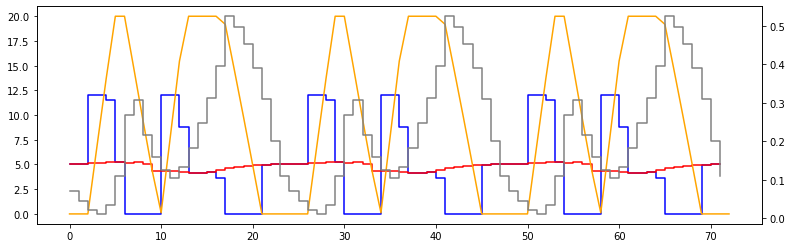

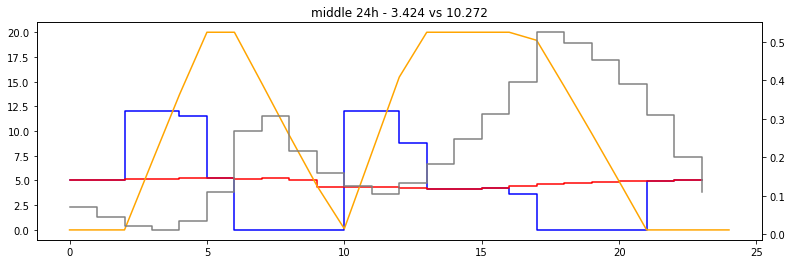


************
MONTH 2
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


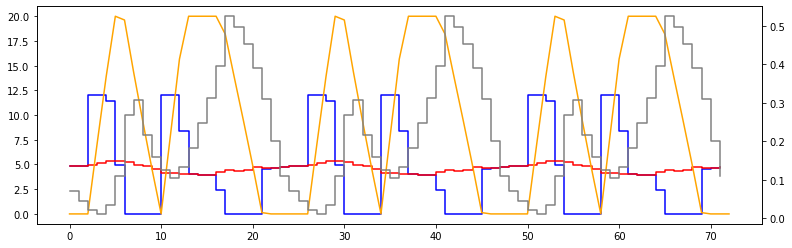

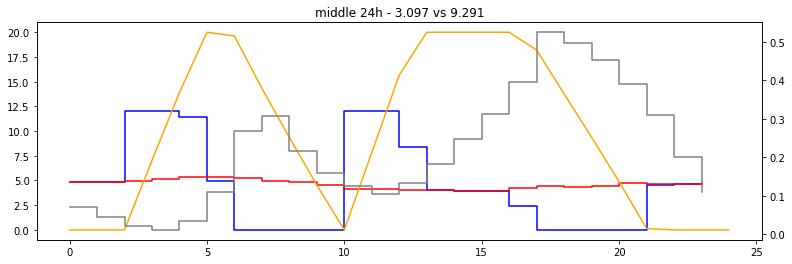


************
MONTH 3
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


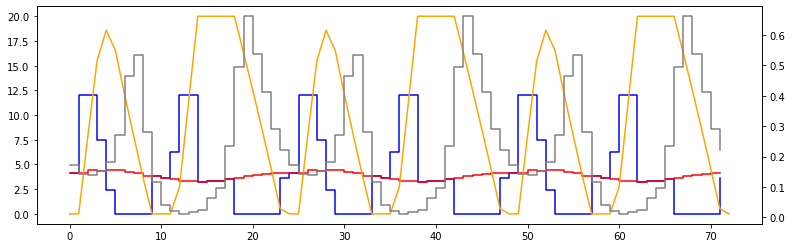

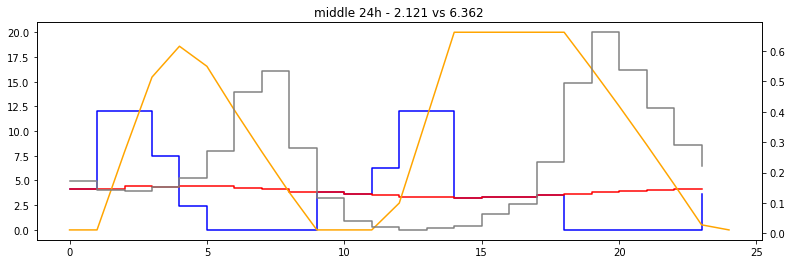


************
MONTH 4
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


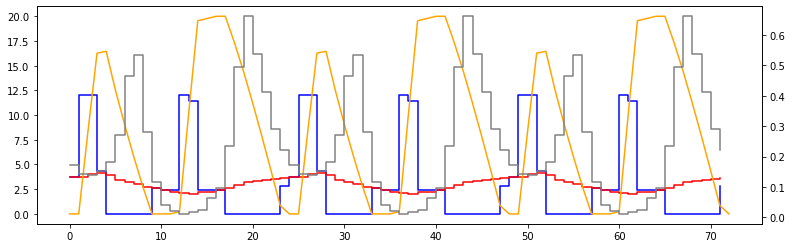

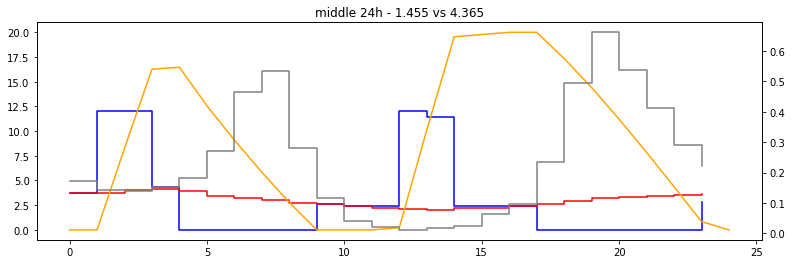


************
MONTH 5
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


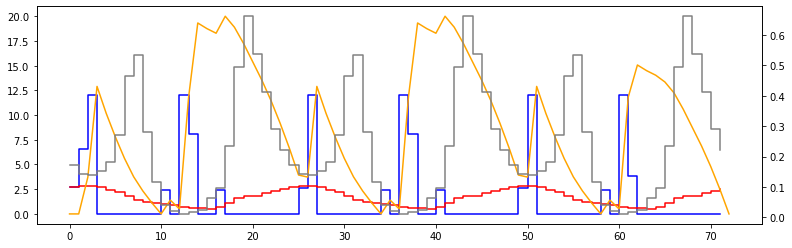

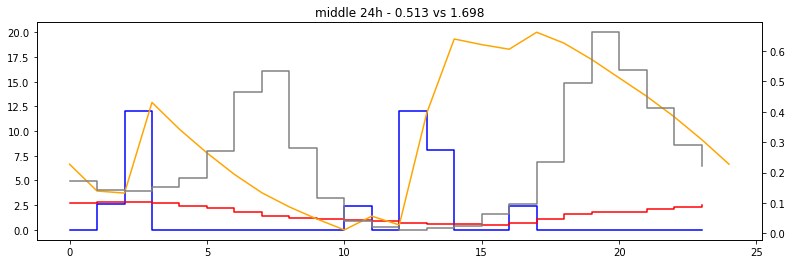


************
MONTH 6
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


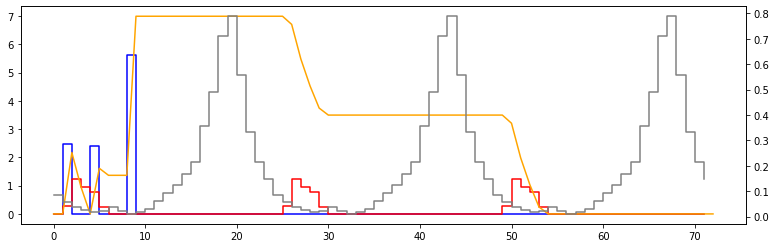

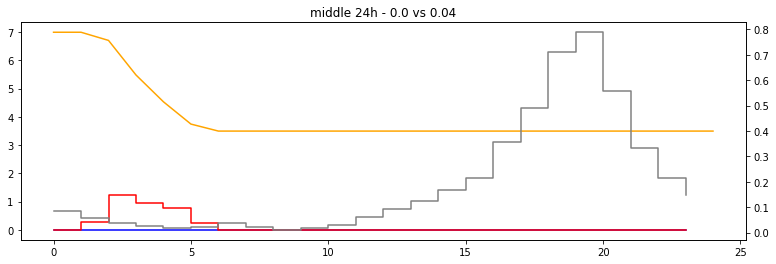


************
MONTH 7
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


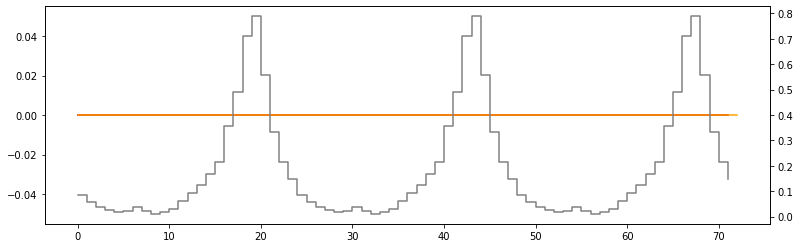

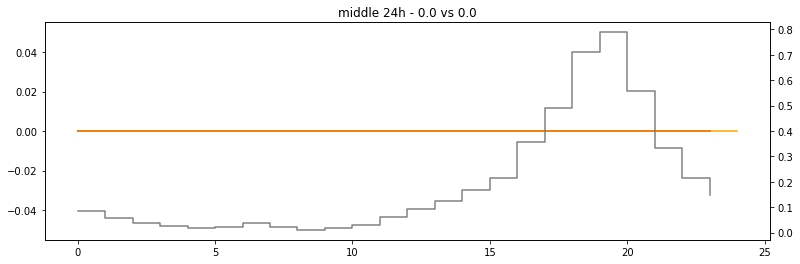


************
MONTH 8
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


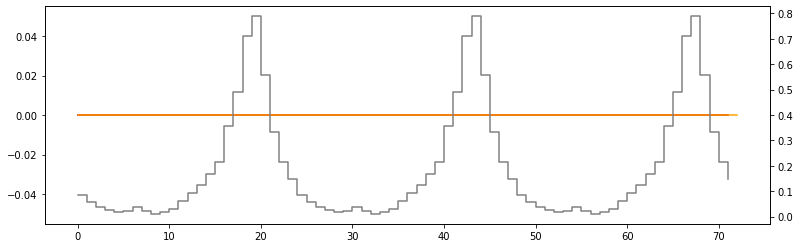

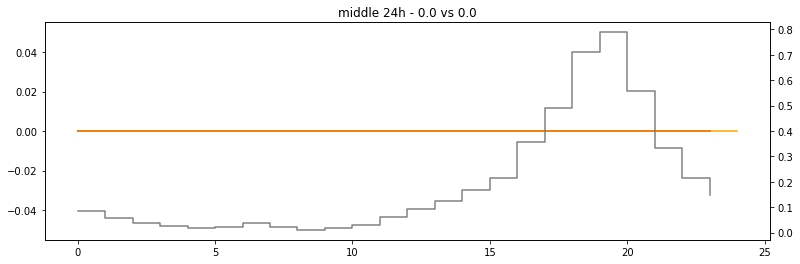


************
MONTH 9
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


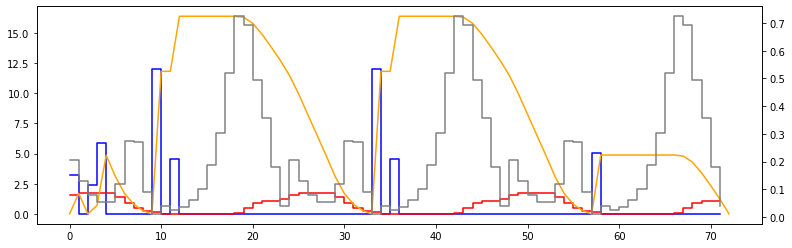

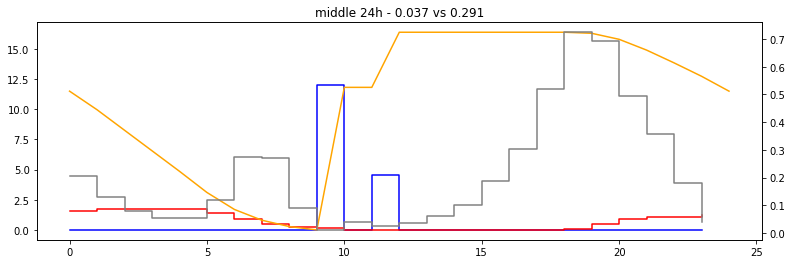


************
MONTH 10
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


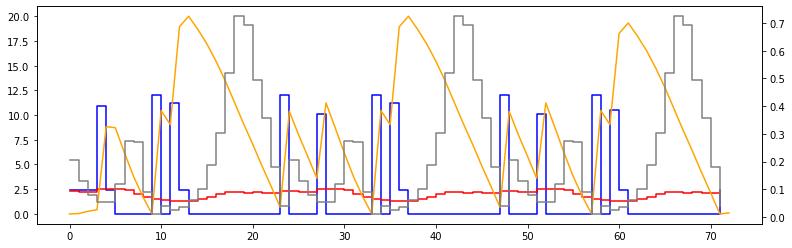

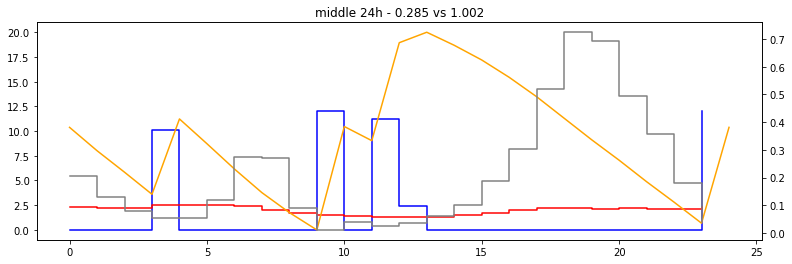


************
MONTH 11
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


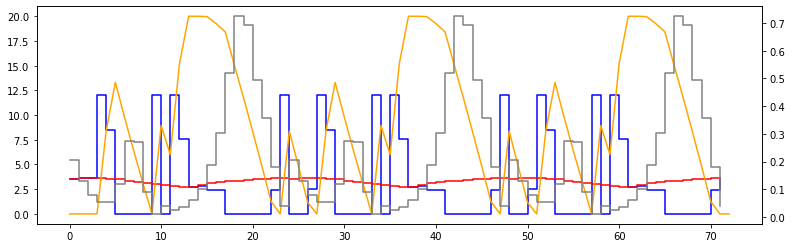

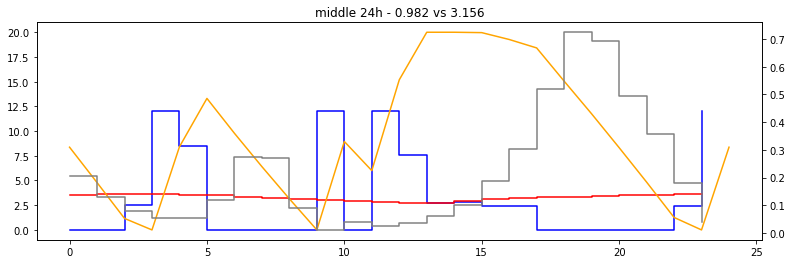


************
MONTH 12
************

Academic license - for non-commercial use only
Academic license - for non-commercial use only


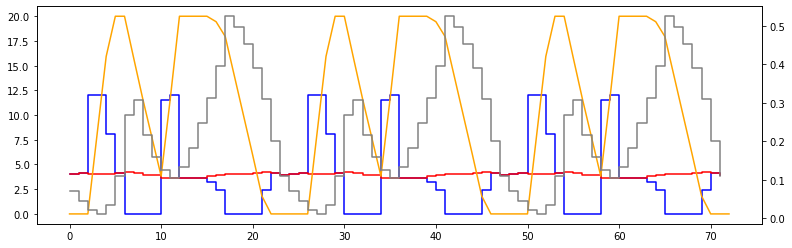

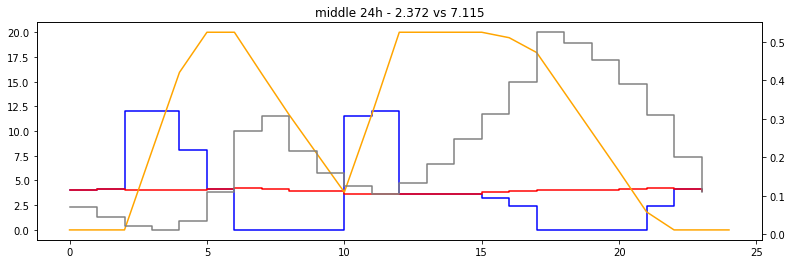

In [105]:
typical_days = []

for i in range(1,13):

    print(f"\n************\nMONTH {i}\n************\n")

    forecasts = {
        'horizon': 24*3,
        'elec': elecs[f'month{i}']*3,
        'load': loads[f'month{i}']*3,
        'T_OA': T_OAs[f'month{i}']*3,
    }

    opex = optimal_opex(20, 12, forecasts)

    typical_days.append(forecasts)

typical_days = [typical_days[1]]



Academic license - for non-commercial use only
Academic license - for non-commercial use only


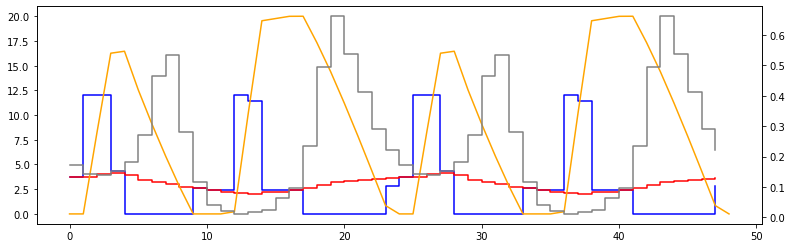

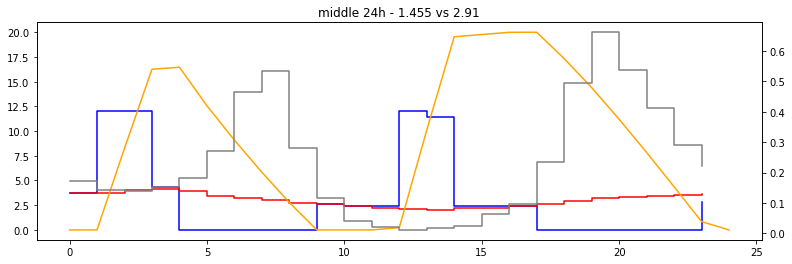

In [106]:
forecasts = {
        'horizon': 24*2,
        'elec': elecs['month5']*2,
        'load': loads['month4']*2,
        'T_OA': T_OAs['month4']*2,
    }

opex = optimal_opex(20, 12, forecasts)

### Get optimal TOTEX for different equipment sizes

In [97]:
def daily_totex(storage_size, heatpump_size, lifetime, forecasts):
    totex=0
    for forecasts in typical_days:

        try:
            capex = estimated_capex(storage_size, heatpump_size, lifetime)
            opex = optimal_opex(storage_size, heatpump_size, forecasts)
            totex += capex + opex
            
        except Exception as e:
            return np.nan

    return totex

In [98]:
lifetime = 20
storage_range = np.linspace(2, 50, 15)
heatpump_range = np.linspace(2, 35, 15)
storage_grid, heatpump_grid = np.meshgrid(storage_range, heatpump_range)

# cost_values = np.vectorize(daily_totex, excluded=['lifetime', 'forecasts'])(storage_grid, heatpump_grid, lifetime, forecasts)

In [99]:
min_index = np.unravel_index(np.nanargmin(cost_values), cost_values.shape)
min_storage_value = storage_grid[min_index]
min_heatpump_value = heatpump_grid[min_index]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

surface = ax.plot_surface(storage_grid, heatpump_grid, cost_values, cmap='viridis', alpha=0.7)
ax.scatter(min_storage_value, min_heatpump_value, cost_values[min_index], color='red', s=100)

ax.set_title(f'Lowest total cost reached for\nHeat pump: {round(min_heatpump_value)} kW, Storage: {round(min_storage_value)} kWh')
ax.set_xlabel('Storage capacity [kWh]')
ax.set_ylabel('Heat pump capacity [kWh]')
ax.set_zlabel('Cost')
ax.set_zticks([])

plt.show()

NameError: name 'cost_values' is not defined